In [2]:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights



#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# Load data

Use the process_data function to load and handle missing data: The missing data is shown below
Building features:
53.4% of the year built
75.5% of the floor count

Weather features:
9.5% of the cloud coverage
0.1% of the dew temperature
36.0% of the precipitation depth
7.6% of the sea level pressure
4.5% of the wind speed
0.2% of the wind direction.

For weather: I filled missing data using average of the closest non missing values of that feature.
For building: I filled the missing data with the mean of the feature for that building's primary use group.

Using load_electricity_education function, I load only data from educational buildings. 

The process_data function also combines the building data with the weather data and both are used together to train the model.

In [3]:
datafolder = '../ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
pd_educational = load_electricity_education(pd_all)

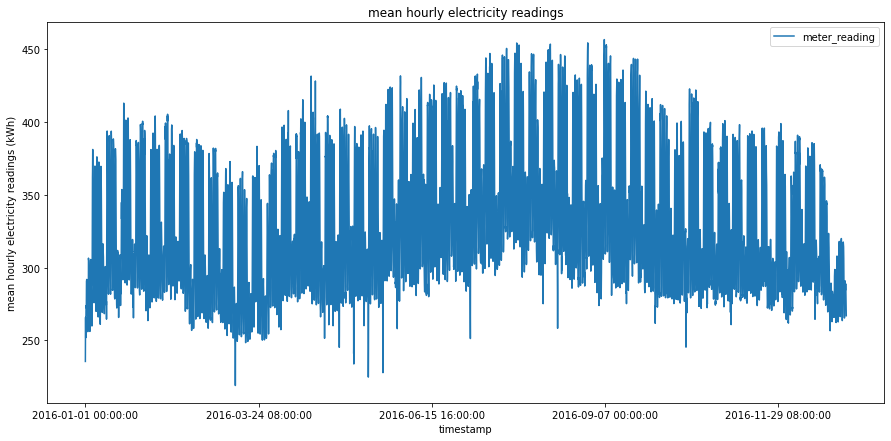

In [4]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly electricity readings (kWh)", title = "mean hourly electricity readings")
plt.show()

The plot above shows the electricity meter data averaged for all educational buildings over 1 year 

I use the first 11 months of data as training data and last month (decemeber) to test.

In [5]:
def split_data_dec(pd_dataframe):
    # split it ~90% on train + validation (11 months) and ~10% on test (1 month)
    pd_educational = pd_dataframe.copy()
    pd_train = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 12, 1)] 
    pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 11, 30)]  
    timestamp_train = pd_train.pop('timestamp')  
    timestamp_test = pd_test.pop('timestamp') 
    
    return pd_train, pd_test, timestamp_train, timestamp_test

The function below does the simple encoding. For simple encoding, I replaced the timestamp feature with hour, weekday, and month features. I also normalized all the input features.

In [6]:
def prepare_data_simple_encoding_dec(pd_dataframe):
  # Timestamp feature encoding:
    ## Looking at the data during data exploration, data shows clear dependence on
    ## time of the day and weekend/weekday. There is also some month variation
    ## of the meter_reading data. I will thus split the timestamp data into month,
    ## weekday and hour that I will then encode using regular numeric encoding (normalize)
    pd_educational = pd_dataframe.copy()
    pd_educational['month'] = pd.to_datetime(pd_educational["timestamp"]).dt.month
    pd_educational['weekday'] = pd.to_datetime(pd_educational["timestamp"]).dt.weekday
    pd_educational['hour'] = pd.to_datetime(pd_educational["timestamp"]).dt.hour
    pd_train, pd_test, timestamp_train, timestamp_test = split_data_dec(pd_educational)
    
    # Normalize the data before we send it to linear regression model to learn this data:
    ## Note: we want to normalize test data using same mean and std as train!
    train_mean = pd_train.mean()
    train_std = pd_train.std()
    
    pd_train = (pd_train - train_mean) / train_std
    pd_test = (pd_test- train_mean) / train_std
    
    train_features = pd_train.copy()
    test_features = pd_test.copy()
    
    train_labels = train_features.pop('meter_reading')
    test_labels = test_features.pop('meter_reading')
    
    return (train_features,train_labels), (test_features,test_labels), timestamp_train, timestamp_test

In [7]:
train_data_s, test_data_s, timestamp_train_s, timestamp_test_s = prepare_data_simple_encoding_dec(pd_educational)

# Linear Regression

Linear regression using simple encoding

In [8]:
linear_regression_model_s, history_s = learn_parameters(train_data_s, test_data_s, 0.00003, 256 )

C:\Users\maxab\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
2809/2809 [==============================] - 11s 3ms/step - loss: 3.3206 - val_loss: 4.0944
Epoch 2/15
2809/2809 [==============================] - 11s 4ms/step - loss: 2.5204 - val_loss: 3.2615
Epoch 3/15
2809/2809 [==============================] - 9s 3ms/step - loss: 1.9248 - val_loss: 2.6085
Epoch 4/15
2809/2809 [==============================] - 12s 4ms/step - loss: 1.4904 - val_loss: 2.1095
Epoch 5/15
2809/2809 [==============================] - 11s 4ms/step - loss: 1.1922 - val_loss: 1.7492
Epoch 6/15
2809/2809 [==============================] - 13s 4ms/step - loss: 0.9973 - val_loss: 1.5072
Epoch 7/15
2809/2809 [==============================] - 13s 4ms/step - loss: 0.8661 - val_loss: 1.3441
Epoch 8/15
2809/2809 [==============================] - 13s 5ms/step - loss: 0.7709 - val_loss: 1.2217
Epoch 9/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.7019 - val_loss: 1.1267
Epoch 10/15
2809/2809 [==============================] - 12s 4ms/step - lo

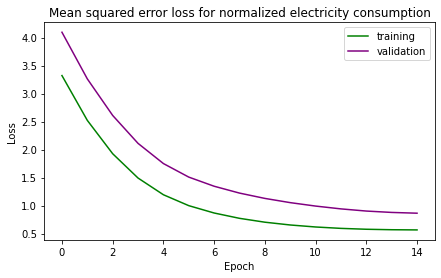

In [9]:
plot_loss_history(history_s)

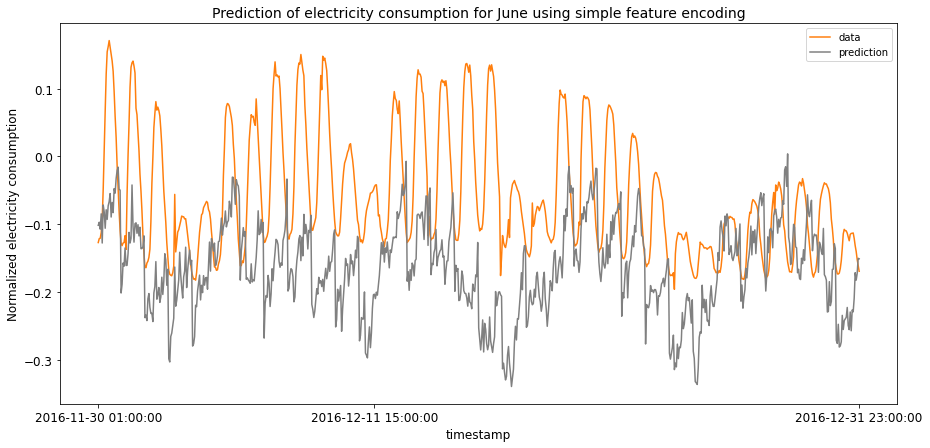

In [10]:
plot_test_and_prediction(test_data_s, timestamp_test_s, linear_regression_model_s, 'simple')

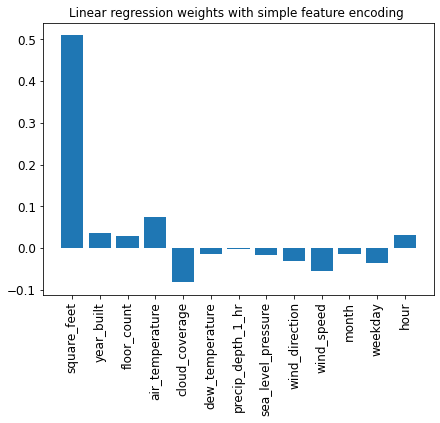

In [11]:
plot_linear_regression_weights(train_data_s,linear_regression_model_s, 'simple')

In [12]:
def calculate_rmse_metric(y_pred,y_test):
  return np.sqrt(np.mean((y_pred - y_test)**2))

The cell below shows the mean squared error metric for linear regression with simple encoding

In [13]:
test_features_s = test_data_s[0]
test_labels_s = test_data_s[1]
test_features_new = test_features_s.copy()
y_pred_s = linear_regression_model_s.predict(test_features_s)
y_norm_s= pd.DataFrame(y_pred_s, columns = ['prediction'])
y_norm_s['timestamp'] = np.array(timestamp_test_s)
test_features_new['meter_reading']  = test_labels_s
test_features_new['timestamp']  = np.array(timestamp_test_s) 

y_test_all = test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_s.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.14439597944748256

The cell below does polynomial encoding to the input data. Specifically, I do polynomial encoding on timestamp and wind features. I also conver the year built feature to a categorical feature using 40 year periods as bins.
For timestamp feature: Given that energy consumption has clear daily variations, if we encode day as a numeric feature, then even though 0000hrs follows right after 2359hrs, they will numerically look like they are far apart. This encoding solves this problem by substituting day feature with day_sin and day_cos feature, with frequency that corresponds to a 24h.
For wind feature: Wind_direction feature in units of degrees has similar issue as described above, where 0 and 359 degrees are numerically far away but in reality they are close. Thus I substituted wind_speed and wind_direction features by combining them together into wind_x and wind_y features.

In [14]:
def prepare_data_polynomial_encoding_dec(pd_dataframe):
    # Wind feature encoding:
    pd_educational = pd_dataframe.copy()
    wind_speed = pd_educational.pop('wind_speed') 
    wind_direction = pd_educational.pop('wind_direction')*np.pi/180 # wind direction in radians 
    
    pd_educational['wind_x'] = wind_speed * np.cos(wind_direction) 
    pd_educational['wind_y'] = wind_speed * np.sin(wind_direction) 
    
    # Timestamp feature encoding:
    timestamp = pd.to_datetime(pd_educational["timestamp"]).map(datetime.datetime.timestamp) 
    day = 24*60*60 
    week = 7*day 
    month = 30*day 
    year = (365.2425)*day 
    pd_educational['day_sin'] = np.sin(timestamp * (2 * np.pi / day)) 
    pd_educational['day_cos'] = np.cos(timestamp * (2 * np.pi / day)) 
    
    pd_educational['week_sin'] = np.sin(timestamp * (2 * np.pi / week)) 
    pd_educational['week_cos'] = np.cos(timestamp * (2 * np.pi / week)) 
    
    pd_educational['year_sin'] = np.sin(timestamp * (2 * np.pi / year)) 
    pd_educational['year_cos'] = np.cos(timestamp * (2 * np.pi / year)) 
    
    pd_educational['is_weekday'] = (pd.to_datetime(pd_educational["timestamp"]).dt.weekday.values < 5).astype(int) 
    
    # Year_built feature encoding:
    ## Looking at the year_built histogram, there seems to be 3 waves of building 
    ## '1900-1940', '1940-1980', '1980-today'. I will split this column in those  
    ## 3 features and I will assign them values 0, 1 and 2:  
    year_built = pd_educational.pop('year_built') 
    pd_educational['year_built_range'] = ((year_built.values-1900)/40).astype(int) 
    
    pd_train, pd_test, timestamp_train, timestamp_test = split_data_dec(pd_educational) 
    
    # Normalize the data before we send it to linear regression model to learn this data: 
    ## Note: we want to normalize test data using same mean and std as train! 
    train_mean = pd_train.mean() 
    train_std = pd_train.std() 
    
    pd_train = (pd_train - train_mean) / train_std 
    pd_test = (pd_test- train_mean) / train_std 
    
    train_features = pd_train.copy() 
    test_features = pd_test.copy() 
    
    train_labels = train_features.pop('meter_reading') 
    test_labels = test_features.pop('meter_reading') 
    
    return (train_features,train_labels), (test_features,test_labels), timestamp_train, timestamp_test

In [15]:
train_data_p, test_data_p, timestamp_train_p, timestamp_test_p = prepare_data_polynomial_encoding_dec(pd_educational) 

In [16]:
linear_regression_model_p, history_p = learn_parameters(train_data_p, test_data_p, 0.00003, 256 )

C:\Users\maxab\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
2809/2809 [==============================] - 11s 4ms/step - loss: 1.4765 - val_loss: 2.0305
Epoch 2/15
2809/2809 [==============================] - 12s 4ms/step - loss: 1.0992 - val_loss: 1.5594
Epoch 3/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.8709 - val_loss: 1.2593
Epoch 4/15
2809/2809 [==============================] - 13s 4ms/step - loss: 0.7297 - val_loss: 1.0732
Epoch 5/15
2809/2809 [==============================] - 9s 3ms/step - loss: 0.6452 - val_loss: 0.9582
Epoch 6/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.5992 - val_loss: 0.8934
Epoch 7/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.5756 - val_loss: 0.8601
Epoch 8/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.5644 - val_loss: 0.8474
Epoch 9/15
2809/2809 [==============================] - 12s 4ms/step - loss: 0.5593 - val_loss: 0.8450
Epoch 10/15
2809/2809 [==============================] - 12s 4ms/step - lo

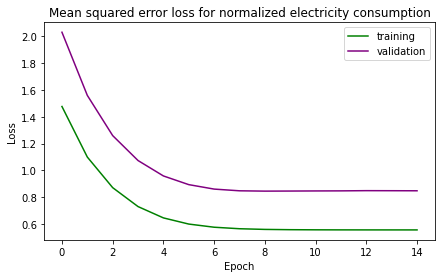

In [17]:
plot_loss_history(history_p)

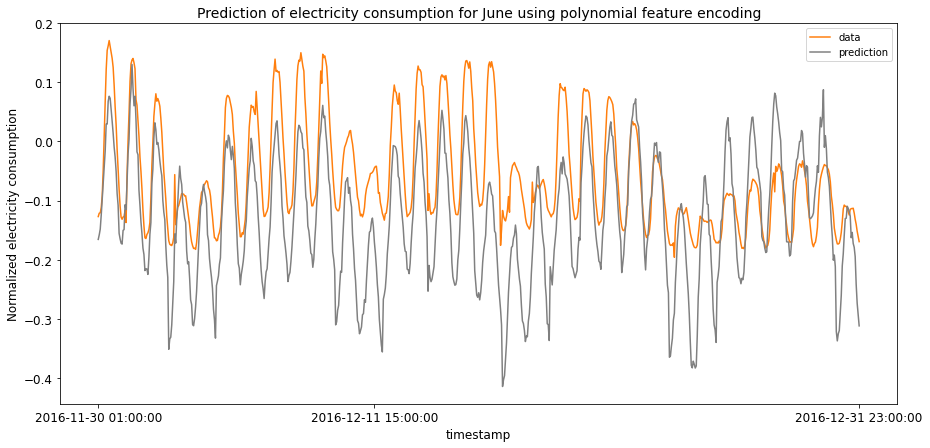

In [18]:
plot_test_and_prediction(test_data_p, timestamp_test_p, linear_regression_model_p, 'polynomial')

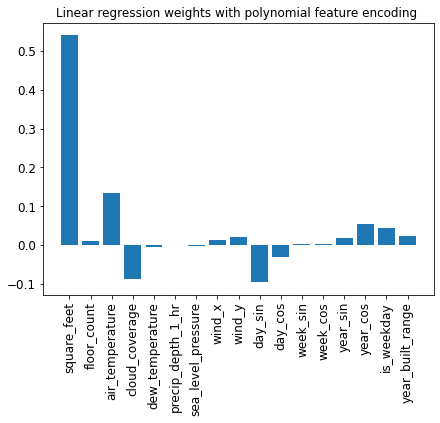

In [19]:
plot_linear_regression_weights(train_data_p,linear_regression_model_p, 'polynomial')

In [20]:
test_features_p = test_data_p[0]
test_labels_p = test_data_p[1]
test_features_new = test_features_p.copy()
y_pred_p = linear_regression_model_p.predict(test_features_p)
y_norm_p= pd.DataFrame(y_pred_p, columns = ['prediction'])
y_norm_p['timestamp'] = np.array(timestamp_test_p)
test_features_new['meter_reading']  = test_labels_p
test_features_new['timestamp']  = np.array(timestamp_test_p) 

y_test_all = test_features_new.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.10480658582030021

# Decision Tree Regression

Decision Tree Regression with Simple Encoding

In [21]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding_dec(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

In [22]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

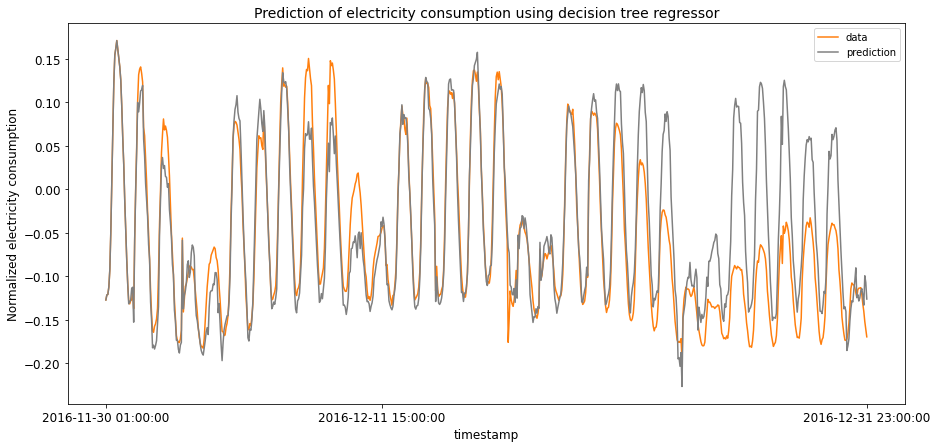

In [23]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [24]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values

calculate_rmse_metric(y_test_all,y_hat_all)

0.04847489835505979

Decision Tree Regrssion with polynomial encoding

In [25]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding_dec(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

In [26]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

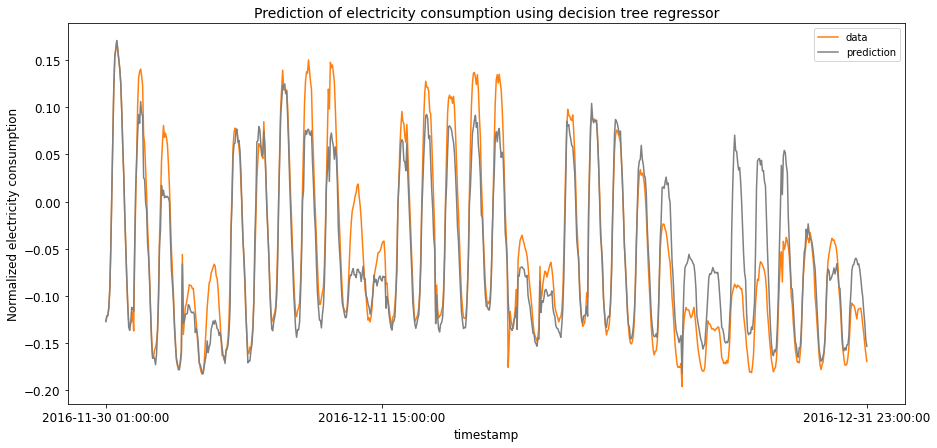

In [27]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [28]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values

calculate_rmse_metric(y_test_all,y_hat_all)

0.03592985271469406

Decision Tree regression with no encoding

In [29]:
pd_train = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 12, 1)] 
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 11, 30)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

In [30]:
clf = tree.DecisionTreeRegressor()#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

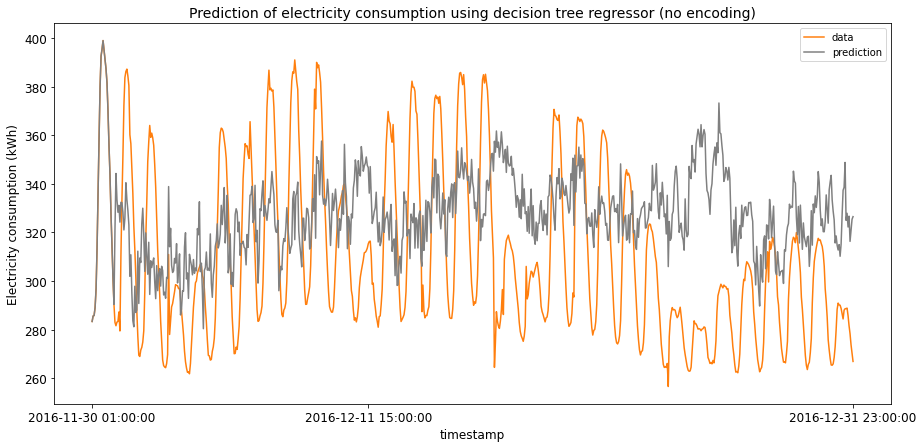

In [31]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor (no encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [32]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.11425437635163778

# Random Forst Regression

Random forest regression with simple encoding

In [33]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_simple_encoding_dec(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

In [34]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

<ipython-input-35-1a7c82564a68>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "transparency" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RFR_simple_Dec.pdf', transparency = True,bbox_inches='tight')


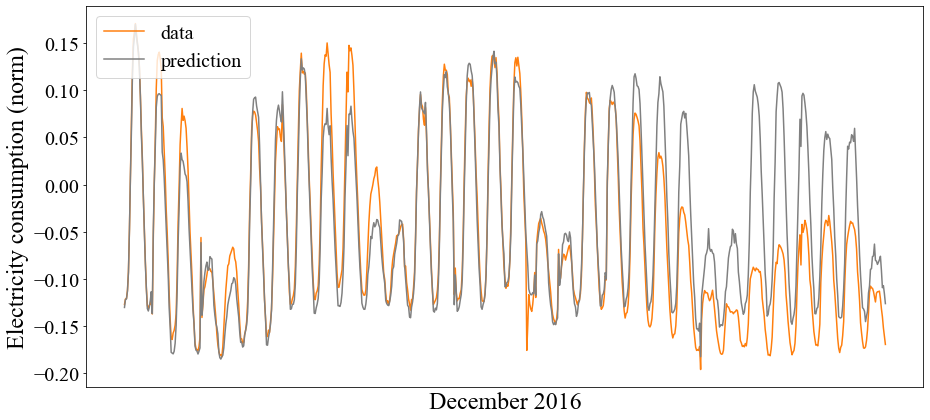

In [35]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
#plt.title('Prediction of electricity consumption using random forest regressor and simple encoding', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([])
#plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
plt.savefig('RFR_simple_Dec.pdf', transparency = True,bbox_inches='tight')
plt.show()

In [36]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.04691576570608957

Random forest regression with polynomial encoding

In [37]:
train_data, test_data, timestamp_train, timestamp_test = prepare_data_polynomial_encoding_dec(pd_educational)
(X_train,y_train) = train_data
(X_test,y_test) = test_data

In [38]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

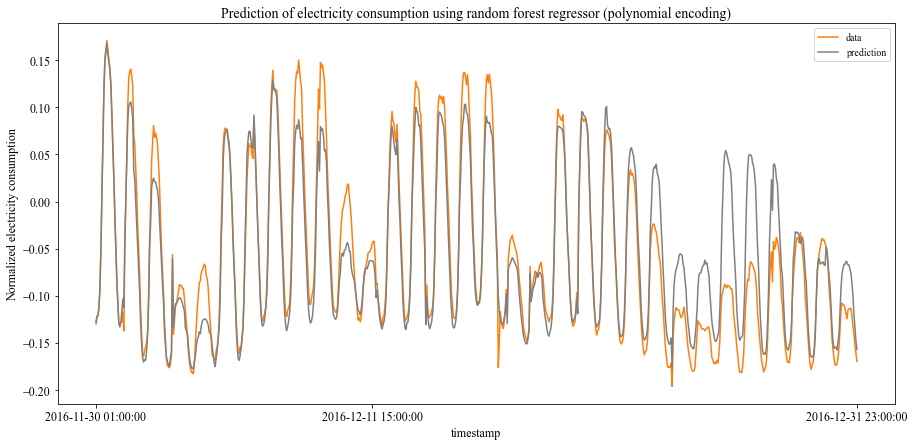

In [39]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Normalized electricity consumption', fontsize = 12)
plt.title('Prediction of electricity consumption using random forest regressor (polynomial encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [40]:
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)

0.033762116209797695

Random forst regression with no encoding

In [41]:
pd_train = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 12, 1)] 
pd_test = pd_educational.loc[pd.to_datetime(pd_educational["timestamp"]) > datetime.datetime(2016, 11, 30)]

y_train = pd_train.pop('meter_reading')
y_test = pd_test.pop('meter_reading')
X_train = pd_train
X_test = pd_test
timestamp_train = X_train.pop('timestamp')
timestamp_test = X_test.pop('timestamp')

In [42]:
clf = RandomForestRegressor(n_estimators=30)#max_depth=400)
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

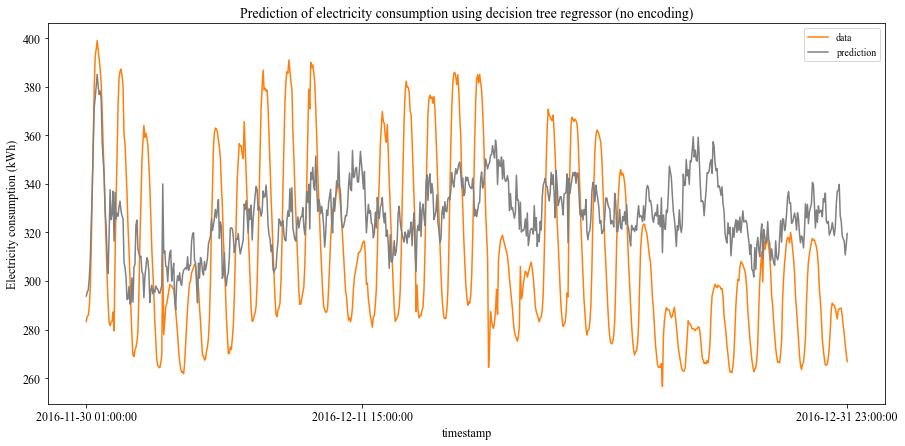

In [43]:
pred = {'prediction': y_hat, 'timestamp': timestamp_test}
y_norm_p = pd.DataFrame(data=pred)
test_val = {'meter_reading':y_test, 'timestamp': timestamp_test}
test_features_new_p= pd.DataFrame(data=test_val)

figure(figsize =(15,7))
plt.plot(test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]), color = 'C1', label = 'data')
plt.plot(y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]), color = 'gray', label = 'prediction')
plt.xlabel('timestamp', fontsize = 12)
plt.ylabel('Electricity consumption (kWh)', fontsize = 12)
plt.title('Prediction of electricity consumption using decision tree regressor (no encoding)', fontsize = 14)
len_ts = len(timestamp_test.values)
plt.xticks([timestamp_test.values[0],timestamp_test.values[int(len_ts/2)],timestamp_test.values[-1]], fontsize = '12')
plt.yticks(fontsize = 12)
plt.legend()
plt.show()

In [44]:
std = np.std(y_test.values)
y_test_all = test_features_new_p.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).meter_reading.values
y_hat_all = y_norm_p.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).prediction.values
calculate_rmse_metric(y_test_all,y_hat_all)/std

0.11045580335694628